In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2

In [2]:
def cal_significant(file_path, fdr):
    significants = dict()
    with open(file_path, "r") as f:
        datas = f.readlines()
        for data in datas[1:]:
            data = data.split()
            if data[0] != data[3] or float(data[6]) > fdr:
                continue
            left1, right1 = int(int(data[1])/1000), int(int(data[2])/1000)
            left2, right2 = int(int(data[4])/1000), int(int(data[5])/1000)
            if abs(left2-left1) > 100 or abs(left2-left1) < 2:
                continue
            if data[0] in ('X', 'Y'):
                continue
            if int(data[0]) not in significants.keys():
                significants[int(data[0])] = []
            significants[int(data[0])].append((left1, left2))
    return significants

def show_venn(enhanced_sig_set, hr_sig_set):
    venn2(subsets = [hr_sig_set, enhanced_sig_set], set_labels = ('1kb', 'enhanced'), set_colors=((247/255, 129/255, 191/255), (51/255, 160/255, 44/255)))
    plt.show()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])


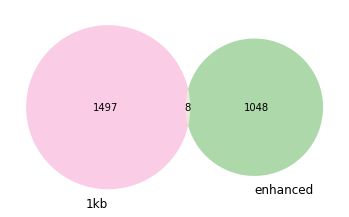

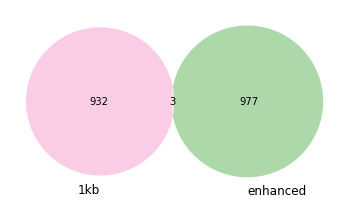

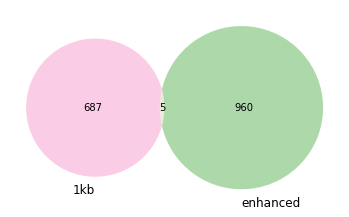

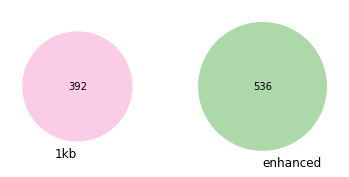

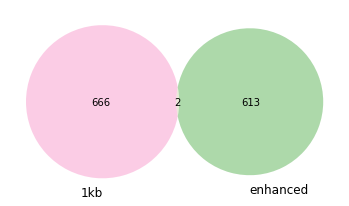

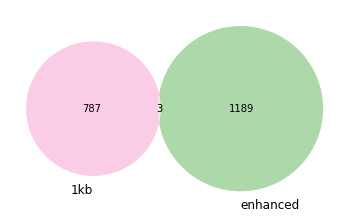

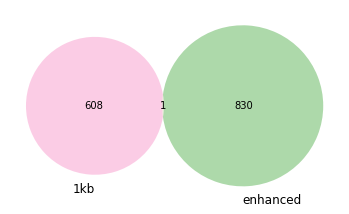

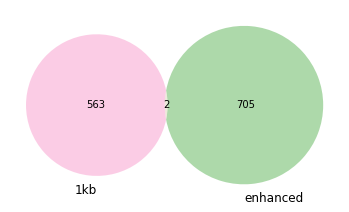

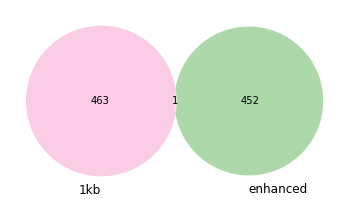

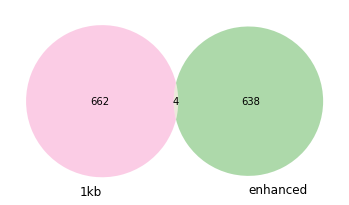

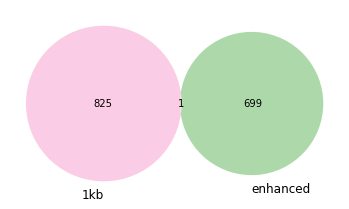

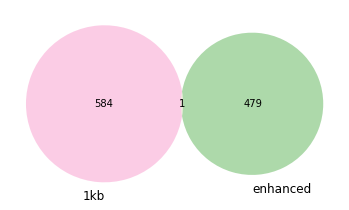

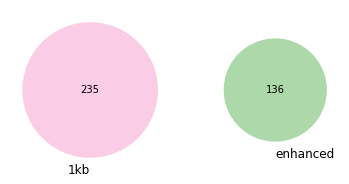

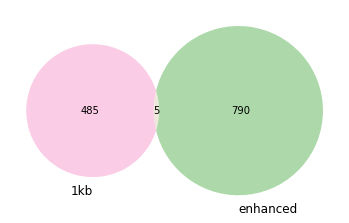

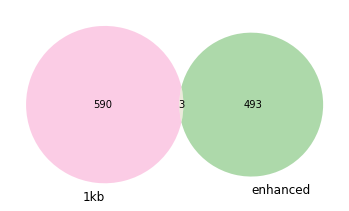

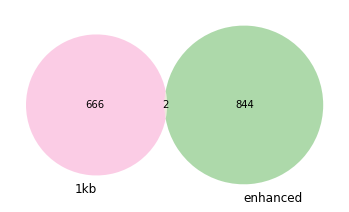

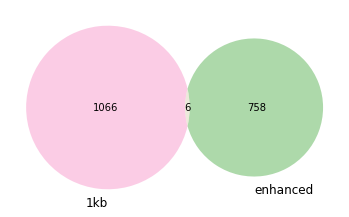

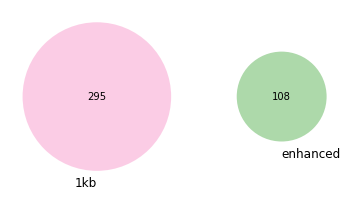

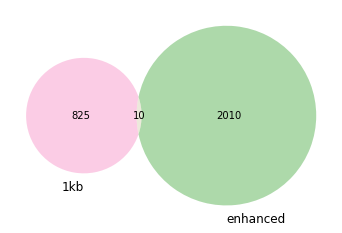

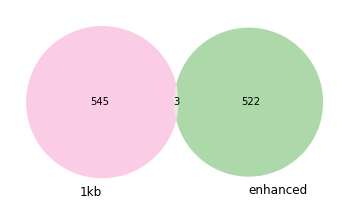

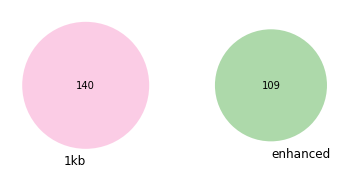

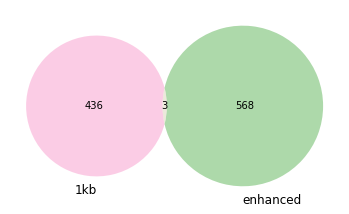

In [3]:
analyse_path = '/data1/lmh_data/MINE/GM12878_ATAC_H3K27ac_H3K4me3/analyse/GM12878_ATAC_H3K27ac_H3K4me3'
enhanced_path = os.path.join(analyse_path, 'experiment', 'mustache', 'enhanced')
hr_path = os.path.join(analyse_path, 'experiment', 'loop', 'hr')
auxiliary_files_path = '/data1/lmh_data/MINE/source/GM12878'

# 未去交集的全部sig
enhanced_sigs = set()
hr_sigs = set()
# 去交集的全部sig
all_enhanced_sig = dict()
all_hr_sig = dict()
hr_file_path = os.path.join(analyse_path, 'experiment', 'mustache', 'hic_out.tsv')
hr_sig = cal_significant(hr_file_path, 0.05)
print(hr_sig.keys())
for chr in range(1, 23):
    if chr not in hr_sig.keys():
        continue
    
    enhanced_file_path = os.path.join(enhanced_path, 'chr{}_1000b'.format(chr), 'enhanced_out_pt05.tsv')
    enhanced_sig = cal_significant(enhanced_file_path, 0.41)
    
    _hr_sig = set(list(map(tuple, np.array(hr_sig[chr])[:, :2])))
    _enhanced_sig = set(list(map(tuple, np.array(enhanced_sig[chr])[:, :2])))
    show_venn(_enhanced_sig, _hr_sig)
    # 去交集
    new_enhanced_sig = _enhanced_sig - _hr_sig
    new_hr_sig = _hr_sig - _enhanced_sig
    
    all_enhanced_sig[chr] = new_enhanced_sig
    all_hr_sig[chr] = new_hr_sig
    
    for sig in _enhanced_sig:
        _sig = list(sig)
        _sig.append('chr{}'.format(chr))
        enhanced_sigs.add(tuple(_sig))
    for sig in _hr_sig:
        _sig = list(sig)
        _sig.append('chr{}'.format(chr))
        hr_sigs.add(tuple(_sig))

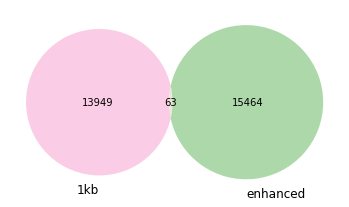

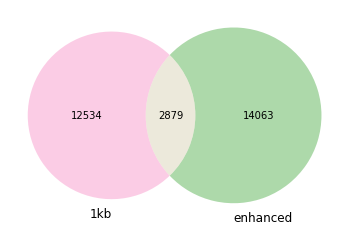

In [4]:
show_venn(enhanced_sigs, hr_sigs)

_enhanced_sigs = enhanced_sigs.copy()
_hr_sigs = set()
for _hr_sig in hr_sigs:
    flag = False
    for _enhanced_sig in _enhanced_sigs:
        if abs(_hr_sig[0]-_enhanced_sig[0])<3 and abs(_hr_sig[1]-_enhanced_sig[1])<3:
            _hr_sigs.add(_enhanced_sig)
            flag = True
    _hr_sigs.add(_hr_sig)
    if flag:
        _enhanced_sigs.add(_hr_sig)

show_venn(_enhanced_sigs, _hr_sigs)

In [5]:
attentions = 50
center = attentions - 1

def read_chiqseq_file(path):
    _peaks = dict()
    with open(path)as f:
        for line in f:
            datas = line.strip().split()
            left, right = int(int(datas[1])/1000), int(int(datas[2])/1000)
            peaks = list(range(left, right+1))
            if datas[0] not in _peaks.keys():
                _peaks[datas[0]] = set()
            for i in peaks:
                _peaks[datas[0]].add(i)
    return _peaks

def get_hit_indicators(significants, peaks):
    distance = np.zeros(attentions*2-1)
    
    for sig in significants:
        x, y = int(sig[0]), int(sig[1])
        for i in range(attentions):
            if (x+i) in peaks or (y+i) in peaks:
                distance[center-i] += 1
            if i != 0 and((x-i) in peaks or (y-i) in peaks):
                distance[center+i] += 1
            if (x+i) in peaks or (x-i) in peaks or (y+i) in peaks or (y-i) in peaks:
                break
    return distance

def show(x, mine_result, hr_result):
    sns.set_style("whitegrid") 
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), sharey=True)
    axes.grid(False)
    axes.plot(x, mine_result, color=(51/255, 160/255, 44/255), label='mine')
    axes.plot(x, hr_result, color=(177/255, 89/255, 40/255), label='hr')

    plt.xlabel('distance')
    plt.ylabel('nums')
    plt.legend()
    plt.show()

def figure(chip_seq_path):
    all_enhanced_result = np.zeros(attentions*2-1)
    all_hr_result = np.zeros(attentions*2-1)

    for chr in range(1, 23):
        if chr not in all_hr_sig.keys():
            continue
        _peaks = read_chiqseq_file(chip_seq_path)
        enhanced_result = get_hit_indicators(all_enhanced_sig[chr], _peaks['chr{}'.format(chr)])
        hr_result = get_hit_indicators(all_hr_sig[chr], _peaks['chr{}'.format(chr)])

        all_enhanced_result += enhanced_result
        all_hr_result += hr_result

    show(list(range(-attentions+1, attentions)), all_enhanced_result, all_hr_result)

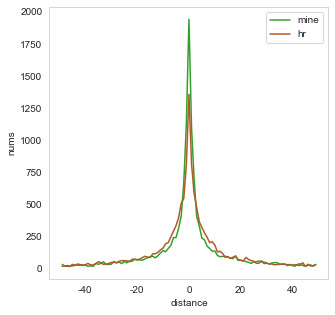

In [6]:
chip_seq_path = os.path.join(auxiliary_files_path, 'CTCF_peaks.bed')
figure(chip_seq_path)

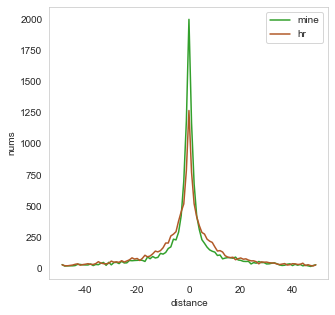

In [7]:
chip_seq_path = os.path.join(auxiliary_files_path, 'RAD21_peaks.bed')
figure(chip_seq_path)

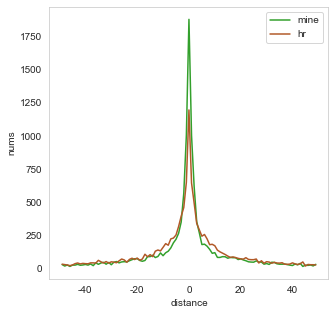

In [8]:
chip_seq_path = os.path.join(auxiliary_files_path, 'SMC3_peaks.bed')
figure(chip_seq_path)

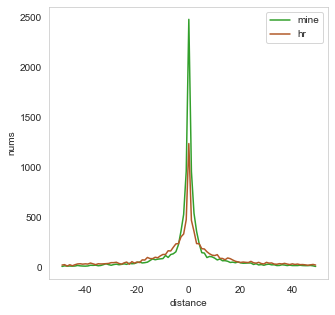

In [9]:
chip_seq_path = os.path.join(auxiliary_files_path, 'POLR2A_peaks.bed')
figure(chip_seq_path)

In [10]:
tss_file_path = os.path.join(auxiliary_files_path, 'Homo_sapiens.GRCh38.104.chr.gff3')

def get_tss_gene_info(gene_biotype='protein_coding'):
    gene_location = dict()
    gene_info = dict()
    with open(tss_file_path, "r") as f:
        datas = f.readlines()
        for data in datas[9:]:
            data = data.split('\t')
            if len(data) < 9:
                continue
            if data[2] != 'gene' or data[8].find(gene_biotype) == -1:
                continue
            if data[6] == '+':
                _location = data[3]
            elif data[6] == '-':
                _location = data[4]
            else:
                print('error')
            if not data[0].isdigit():
                continue
            chromosome = int(data[0])
            if chromosome not in gene_location:
                gene_location[chromosome] = set()
            gene_location[chromosome].add(int(int(_location)/1000))
            
            _tmp = data[-1].split('Name=')
            if len(_tmp) < 2:
                continue
            gene_names = _tmp[1].split(';')[0]
            gene_ids = data[-1].split('ID=')[1].split(',')[0].split(';')[0]
            
            if chromosome not in gene_info:
                gene_info[chromosome] = set()
            gene_info[chromosome].add((int(int(_location)/1000), gene_names, gene_ids, data[-1].replace('\n', '')))
    return gene_location, gene_info

def figure_tss(locations):
    all_enhanced_result = np.zeros(attentions*2-1)
    all_hr_result = np.zeros(attentions*2-1)

    for chr in range(1, 23):
        if chr not in locations:
            continue
        enhanced_result = get_hit_indicators(all_enhanced_sig[chr], locations[chr])
        hr_result = get_hit_indicators(all_hr_sig[chr], locations[chr])

        all_enhanced_result += enhanced_result
        all_hr_result += hr_result

    show(list(range(-attentions+1, attentions)), all_enhanced_result, all_hr_result)

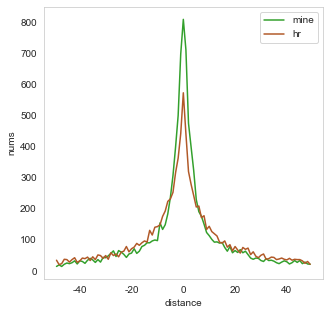

In [11]:
figure_tss(get_tss_gene_info('protein_coding')[0])

In [12]:
def get_hit_genes(significants, gene_info, genes_loop_nums):
    genes = set()
    for sig in significants:
        x, y = int(sig[0]), int(sig[1])
        for _info in gene_info:
            if abs(x-_info[0])<3 or abs(y-_info[0])<3:
                if _info[1] not in genes_loop_nums:
                    genes_loop_nums[_info[1]] = 1
                else:
                    genes_loop_nums[_info[1]] += 1
                genes.add((_info[1], _info[2], _info[3]))
    return genes, genes_loop_nums

def get_hit_gene_names(significants, gene_biotype='protein_coding'):
    gene_info = get_tss_gene_info(gene_biotype)[1]
    all_genes = set()
    genes_loop_nums = dict()
    for chr in range(1, 23):
        genes, genes_loop_nums = get_hit_genes(significants[chr], gene_info[chr], genes_loop_nums)
        all_genes = all_genes | genes
    return all_genes, genes_loop_nums

In [13]:
mine_hit_genes, mine_genes_loop_nums = get_hit_gene_names(all_enhanced_sig, gene_biotype='protein_coding')
mine_hit_genes = list(mine_hit_genes)
mine_hit_genes = np.array(mine_hit_genes)
print(len(mine_hit_genes))
print(mine_genes_loop_nums.keys())

2563
dict_keys(['EFCAB2', 'PLA2G4A', 'CEP104', 'DFFB', 'SEMA4A', 'E2F2', 'PIK3C2B', 'GPR89A', 'INPP5B', 'SAMD11', 'AIDA', 'CD84', 'TNFRSF18', 'ZBTB37', 'PHTF1', 'TRIM46', 'KRTCAP2', 'HNRNPU', 'HIPK1', 'CD160', 'FAM72D', 'SRGAP2B', 'LRRC42', 'HSPB11', 'SELENOF', 'HS2ST1', 'NRAS', 'MATN1', 'RABGAP1L', 'ZNF670', 'ZNF670-ZNF695', 'AKR1A1', 'TBCE', 'ARID4B', 'GGPS1', 'CDK11A', 'CDK11B', 'SLC30A1', 'HSPA6', 'CR2', 'CHIT1', 'CSRP1', 'RCC1', 'RCC2', 'PDZK1', 'FLVCR1', 'FAM102B', 'RHEX', 'MOV10', 'RHOC', 'ST7L', 'PIK3R3', 'LCE1C', 'LCE1F', 'ITPKB', 'KCTD3', 'H2BC21', 'BOLA1', 'H2AC20', 'H2AC21', 'SPATA1', 'GNG5', 'PRDM2', 'TMEM50A', 'RSRP1', 'CTTNBP2NL', 'PADI2', 'MTX1', 'GNB1', 'IL19', 'H3C13', 'NSUN4', 'LRRC41', 'UQCRH', 'CD58', 'RNF19B', 'SMYD2', 'FCRLA', 'MIA3', 'AGMAT', 'BTG2', 'FDPS', 'CLK2', 'HCN3', 'DYRK3', 'LCE3C', 'PSMB2', 'EXO5', 'ZFP69', 'IPO13', 'DPH2', 'LAMC1', 'EIF3I', 'TMEM234', 'CCNL2', 'MAN1A2', 'CLSTN1', 'RLF', 'PMF1', 'PMF1-BGLAP', 'CZIB', 'MAGOH', 'WRAP73', 'TP73', 'RGS1', 

In [14]:
hr_hit_genes, hr_genes_loop_nums = get_hit_gene_names(all_hr_sig, gene_biotype='protein_coding')
hr_hit_genes = list(hr_hit_genes)
hr_hit_genes = np.array(hr_hit_genes)
print(len(hr_hit_genes))
print(hr_genes_loop_nums.keys())

2002
dict_keys(['RXFP4', 'FHAD1', 'EFCAB2', 'YTHDF2', 'AHDC1', 'GADD45A', 'CELA2B', 'WNT2B', 'KIAA0040', 'UBXN11', 'DDI2', 'AGMAT', 'ID3', 'NIBAN1', 'NID1', 'IL6R', 'SH2D5', 'MAD2L2', 'DRAXIN', 'CENPS-CORT', 'CENPS', 'IVL', 'RABIF', 'ARHGEF2', 'PSEN2', 'TRIM62', 'ZNF684', 'PIK3C2B', 'FCRL6', 'HMGCL', 'PDIK1L', 'NRDC', 'RSC1A1', 'LMX1A', 'BLACAT1', 'LEMD1', 'TRNAU1AP', 'CCDC18', 'NPR1', 'SPEN', 'SH3D21', 'THRAP3', 'PLEKHM2', 'GFI1', 'MTR', 'SEMA6C', 'KIF21B', 'UBE2U', 'FNDC5', 'PHC2', 'FAM177B', 'MICOS10', 'CAPZB', 'FAM102B', 'HSPA6', 'ASH1L', 'MYCL', 'OPRD1', 'POGK', 'CELA3B', 'CELA3A', 'GSTM5', 'GSTM2', 'DAP3', 'YY1AP1', 'WDTC1', 'CELA2A', 'KIF17', 'WASF2', 'IFI6', 'DOCK7', 'MATN1', 'H3-3A', 'HNRNPU', 'COX20', 'SRSF10', 'MYBPHL', 'FBXO44', 'FBXO2', 'GPR3', 'MOV10', 'SDC3', 'RIT1', 'MARCKSL1', 'CR2', 'KCNC4', 'EPB41', 'TBCE', 'ARID4B', 'GGPS1', 'SETDB1', 'ZBTB7B', 'RAB3B', 'SPRR2A', 'ARID1A', 'SLC2A1', 'CRTC2', 'DENND4B', 'SEMA4A', 'ADAR', 'SMIM1', 'ALDH4A1', 'IFFO2', 'LAMTOR5', 'FAM43

In [15]:
np.save('temp/GM12878_ATAC_H3K27ac_H3K4me3_2_100_mustache_all_enhanced_sig.npy', all_enhanced_sig)
np.save('temp/GM12878_ATAC_H3K27ac_H3K4me3_2_100_mustache_all_hr_sig.npy', all_hr_sig)

np.save('temp/GM12878_ATAC_H3K27ac_H3K4me3_2_100_mustache_enhanced_sigs.npy', enhanced_sigs)
np.save('temp/GM12878_ATAC_H3K27ac_H3K4me3_2_100_mustache_hr_sigs.npy', hr_sigs)

np.save('temp/GM12878_ATAC_H3K27ac_H3K4me3_2_100_mustache__enhanced_sigs.npy', _enhanced_sigs)
np.save('temp/GM12878_ATAC_H3K27ac_H3K4me3_2_100_mustache__hr_sigs.npy', _hr_sigs)